# Modeling: 2nd Iteration of Logistic Regression
---
#### Import libraries and read data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
df = pd.read_csv('../data/explored_skincare.csv')

df.head(2)

,author,title,selftext,num_comments,score,subreddit,is_ab,title_word_count,title_char_count,selftext_word_count,selftext_char_count,combined_text
0,lululi_lululi,working seasoned estheticians hundreds consult...,project glowism https glowism friend female en...,4,1,asianbeauty,1,10,95,259,2031,working seasoned estheticians hundreds consult...
1,BasicBake,wash water,hello wondering wash water usually refrained w...,8,2,asianbeauty,1,1,10,35,237,wash water hello wondering wash water usually ...


## Assign $X$ and $y$ variables
---

In [3]:
features = [
    'combined_text',
    'num_comments',
    'score',
    'title_word_count',
    'title_char_count',
    'selftext_word_count',
    'selftext_char_count']

In [4]:
X = df[features]
y = df['is_ab']

## Train-test-split data
---

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42,
                                                   stratify = y)

## Set and fit model
---
**The Model**

The second iteration of the Logistic Regression model utilized the,
- `penalty` of l2 (ridge regularization),
- `ngram_range` of word pairs (2,2),
- custom stopwords, and
- `cv` of 5 folds.



##### Step 1: Define functions to grab each features separately

In [6]:
numeric = FunctionTransformer(lambda x: x.drop(columns = 'combined_text'), validate = False)

category = FunctionTransformer(lambda x: x['combined_text'], validate = False)

# Riley Dallas and Daniel Kim

##### Step 2: Set a pipeline with transformers and an estimator

In [7]:
pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_pipe', Pipeline([
                ('selector', numeric),
                ('ss', StandardScaler())
            ])),
            ('category_pipe', Pipeline([
                ('selector', category),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])

# Daniel Kim

##### Step 3: Set parameters for gridsearch

In [8]:
custom_stopwords = pickle.load(open('../assets/custom_stopwords.pkl', 'rb'))

In [9]:
params = {
    'features__category_pipe__cvec__stop_words' : [custom_stopwords],
    'features__category_pipe__cvec__ngram_range' : [(2,2)],
    'logreg__penalty' : ['l2']
}

##### Step 4: Instantiate and fit gridsearch

In [10]:
gs = GridSearchCV(pipe, params, cv=5)

gs.fit(X_train, y_train);

## Evaluate Model
---
**Accuracy scores**

The differing accuracy scores are evidence that this model is overfit. However, it is still correctly predicting approx. 90% of unseen data.

We can use this model in production given it's chance of misclassifying is only around 10% of the time. More importantly, given that there are a lot of overlapping topics covered by the two subreddits as seen in EDA, the risk of misclassification is low. A user might still find her answers in the subreddit we send them to.

**Confusion matrix**

Moreover, when we look at the test data confusion matrix heatmap below, the model is slightly better at predicting True Negatives (yellow box) than True Positives (green box). We expect to have a fairly even split between correct predictions given our effort to have a balanced class to begin with. However, this slight imbalance is expected, because we removed keywords that helped predict AsianBeauty ($y$ = 1). This trade off is neccessary to gain valuable insights to which topics are discussed more often in the AsianBeauty subreddit and consequently serve the goal of Ask Gigi.

**Coefficient weights**

Which brings me to coefficient weights. Looking at the coefficient weights, we can see the features and/or words that are most contributive to predicting if an observation is from the AsianBeauty subreddit or not. Because, all else held constant, if a feature has a coefficient weight of 10, a 1 unit increase in the feature means a 10x increase in odds that the observation is of class $y$ = 1. However, if another feature has a weight of 0, a 1 unit increase in the feature does not change the odds of an observation being $y$ = 1.

In other words, I gain insights to which topis are discussed more often in the AsianBeauty subreddit than the alternative by looking at the strongest coefficient weights. 

In this second iteration, I'm looking into word pairs instead of a word by itself. I found this to be most helpful in understanding the context of discussions covered in AsianBeauty. The top 20 word pairs includes the keywords that are related to the keywords we found to be statistically significant tells in EDA except for words regarding 'oily'.

Most of the words in the top 20 word pairs were found in EDA such as sheet masks, snail, and cosrx. But the more interesting findings include mentions of sunscreen, dry (skin), and plastic surgery. The first two topics were showing up more in the SkincareAddiction subreddit and I expected them to have low coefficient weights. However, we did analyze word frequency in EDA on their own, thus the word pair, 'plastic surgery,' was not indicated.

### Calculate accuracy scores

In [11]:
print(f'Train Score: {gs.score(X_train, y_train)}')
print(f'Train Score: {gs.score(X_test, y_test)}')

Train Score: 0.9996979536358831
Train Score: 0.8668176670441676


### Plot confusion Matrices

##### Train data

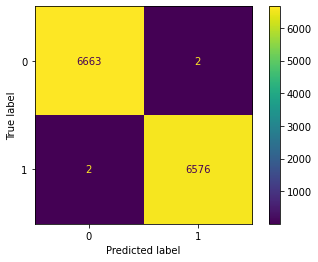

In [12]:
plot_confusion_matrix(gs, X_train, y_train, values_format='.0f');

##### Test data

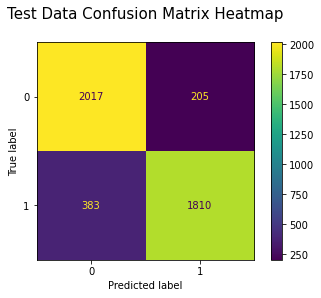

In [13]:
plot_confusion_matrix(gs, X_test, y_test, values_format='.0f');

plt.title('Test Data Confusion Matrix Heatmap\n', size=15)

plt.savefig('../plots/test_conf_matrix_lg_model2.png', dpi=235, bbox_inches='tight')

### Check coefficient weights

In [14]:
coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

feature_names = ['num_comments','score','title_word_count','title_char_count','selftext_word_count','selftext_char_count'] + \
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

coef_df = pd.DataFrame({'features': feature_names, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]
             })

# Daniel Kim

In [15]:
#pd.set_option('display.max_rows', 100)
round(coef_df.sort_values('exp_coef', ascending=False),2).head(20)

# Daniel Kim

,features,coef,exp_coef
1,score,8.86,7065.40
403154,sheet masks,1.81,6.14
36527,bb cream,1.56,4.76
140699,etude house,1.33,3.77
403149,sheet mask,1.33,3.77
190278,hada labo,1.12,3.06
36530,bb cushion,1.09,2.97
207366,https redd,1.04,2.83
104817,cushion foundation,1.03,2.81
415669,snail essence,0.99,2.68


### Plot top 20 word pairs

In [16]:
top_20_words = coef_df.loc[4:][['features','exp_coef']].sort_values('exp_coef', ascending=True).tail(20)

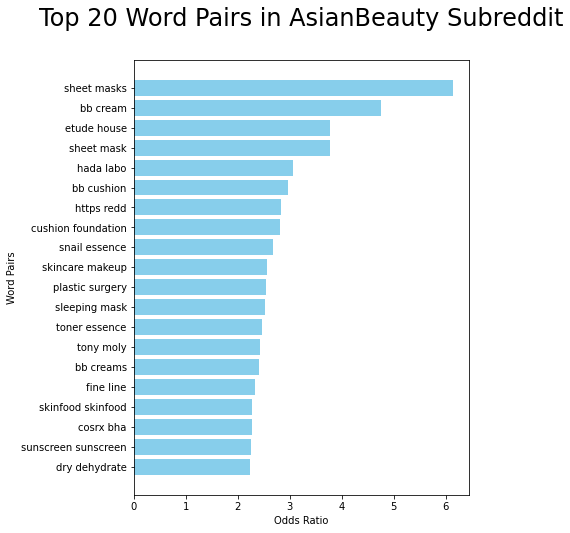

In [17]:
plt.figure(figsize=(6,8))
plt.barh(top_20_words['features'].values,
         top_20_words['exp_coef'].values,
        color='skyblue')

plt.title('Top 20 Word Pairs in AsianBeauty Subreddit\n', fontsize=24)
plt.xlabel('Odds Ratio')
plt.ylabel('Word Pairs');

plt.savefig('../plots/top_20_words_lg_model2.png', dpi=235, bbox_inches='tight')